# Introduction


![alt text](https://raw.githubusercontent.com/Fournierp/OCR/master/Digit%20Recognition/digits.png)

This notebook is the source code used for the submissions for [Kaggle Competition](https://www.kaggle.com/c/digit-recognizer). The goal of the competition is to classify images from the [MNIST handwritten digit database](http://yann.lecun.com/exdb/mnist/). The solution developed produced 99.928% accuracy and got me to 60th place (top 3%).

The approach I took was to perform an Exploratory Data Analysis which enabled me to notice that the data was not noisy but that not all pixels in the images were useful. Thus I could do some Dimensionality Reduction. I build a simple Convolutional Neural Network (CNN) using Keras. The steps I followed are (as described in the [Jupyter Notebook](https://github.com/Fournierp/OCR/tree/master/Digit%20Recognition/Digit%20Recognition.ipynb)) to do normalization, reshaping, data augmentation and training with an Adam Optimizer and a ReduceLROnPlateau callback.

# Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.datasets import mnist
from keras.utils.np_utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Conv2D, Dense, Dropout, Flatten, Input, MaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras import backend as K

Using TensorFlow backend.


# Data Preprocessing

In [2]:
# Load the Kaggle data
train_df = pd.read_csv("../input/train.csv")
test_df = pd.read_csv("../input/test.csv")
y_train_kaggle = train_df["label"]
x_train_kaggle = np.array(train_df.drop(["label"], 1))
x_train_kaggle = x_train_kaggle.reshape(-1, 28, 28)

# Load the Keras Data
(x_train_keras, y_train_keras), (x_test_keras, y_test_keras) = mnist.load_data()
x_train_keras = np.concatenate((x_test_keras, x_train_keras))
y_train_keras = np.concatenate((y_test_keras, y_train_keras))

# Merge the data
x_train = np.concatenate((x_train_kaggle, x_train_keras))
y_train = np.concatenate((y_train_kaggle, y_train_keras))

11493376/11490434 [==============================] - 0s 0us/step


## Normalization

To avoid exploding gradients in our CNN, we will normalize our data.

In [3]:
x_train = np.array(x_train)
x_train_normalized = x_train/255
test_df = np.array(test_df)
test_df_normalized = test_df/255

## Reshape

The data is currently a Pandas Dataframe with each value representing a pixel intensity. If we want to use a Convolutional Neural Network and harness its ability to capture the spatial relationship of pixels, we need to convert it to a Numpy Array of 28 pixels by 28 pixels.

In [4]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
x_train = x_train_normalized.reshape(-1, 28, 28, 1)
test_df = test_df_normalized.reshape(-1, 28, 28, 1)

In [5]:
print(x_train.shape, test_df.shape)

(112000, 28, 28, 1) (28000, 28, 28, 1)


# Exploratory Data Analysis

Let us now look at our data. 

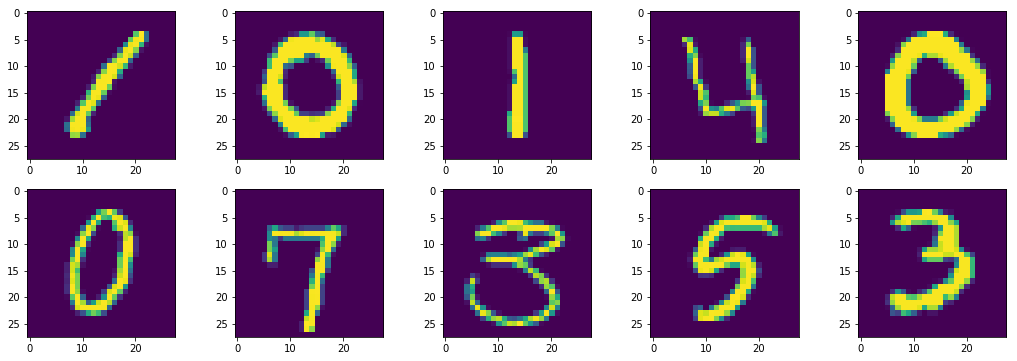

In [6]:
fig, ((ax1, ax2, ax3, ax4, ax5), (ax6, ax7, ax8, ax9, ax10)) = plt.subplots(2, 5, figsize=(18, 6))

g = ax1.imshow(x_train[0][:, :, 0])
g = ax2.imshow(x_train[1][:, :, 0])
g = ax3.imshow(x_train[2][:, :, 0])
g = ax4.imshow(x_train[3][:, :, 0])
g = ax5.imshow(x_train[4][:, :, 0])
g = ax6.imshow(x_train[5][:, :, 0])
g = ax7.imshow(x_train[6][:, :, 0])
g = ax8.imshow(x_train[7][:, :, 0])
g = ax9.imshow(x_train[8][:, :, 0])
g = ax10.imshow(x_train[9][:, :, 0])

From the sampled digits, we can deduce that the images are not filled with noise.

We will now graph the average digit per label of the training data.

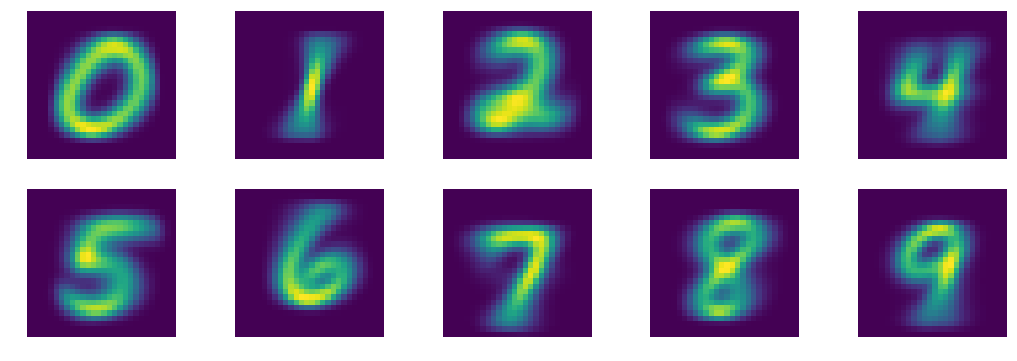

In [7]:
fig, ((ax1, ax2, ax3, ax4, ax5), (ax6, ax7, ax8, ax9, ax10)) = plt.subplots(2, 5, figsize=(18, 6))
ax1.axis('off'), ax2.axis('off'), ax3.axis('off'), ax4.axis('off'), ax5.axis('off'),
ax6.axis('off'), ax7.axis('off'), ax8.axis('off'), ax9.axis('off'), ax10.axis('off'), 

digit = x_train[y_train == 0]
g = ax1.imshow(np.average(digit, 0)[:, :, 0])
digit = x_train[y_train == 1]
g = ax2.imshow(np.average(digit, 0)[:, :, 0])
digit = x_train[y_train == 2]
g = ax3.imshow(np.average(digit, 0)[:, :, 0])
digit = x_train[y_train == 3]
g = ax4.imshow(np.average(digit, 0)[:, :, 0])
digit = x_train[y_train == 4]
g = ax5.imshow(np.average(digit, 0)[:, :, 0])
digit = x_train[y_train == 5]
g = ax6.imshow(np.average(digit, 0)[:, :, 0])
digit = x_train[y_train == 6]
g = ax7.imshow(np.average(digit, 0)[:, :, 0])
digit = x_train[y_train == 7]
g = ax8.imshow(np.average(digit, 0)[:, :, 0])
digit = x_train[y_train == 8]
g = ax9.imshow(np.average(digit, 0)[:, :, 0])
digit = x_train[y_train == 9]
g = ax10.imshow(np.average(digit, 0)[:, :, 0])

We can interpret these graphs to be the conclusive pixels in an image: pixels that will be interpreted by the Neural Network to classify digits. We can observe that each digit has some dead pixels, pixels that are not lit up. We can further observe that some pixels are not used by any digit (the corners for instance). Thus we ought to perform some Dimentionality Reduction to reduce the size of the data that will be fed to the Neural Network.
## Dimensionality Reduction
Let us explore Principle Component Analysis to reduce the number of features in our MNIST Data. In short PCA is a method of selecting the fewest Components (or features) that capture maximum variance. Firstly, we will select the best features (Principle Component) in our data such that they make up 95% of the Variance in the data. Then we will reconstruct our images from the selected Principle Components.

In [8]:
pca = PCA(.95)
lower_dimensional_train = pca.fit_transform(x_train.reshape(-1, 28*28))
lower_dimensional_test = pca.transform(test_df.reshape(-1, 28*28))
pca.n_components_

154

In [9]:
# Reconstruct
approximation_train = pca.inverse_transform(lower_dimensional_train)
approximation_test = pca.inverse_transform(lower_dimensional_test)

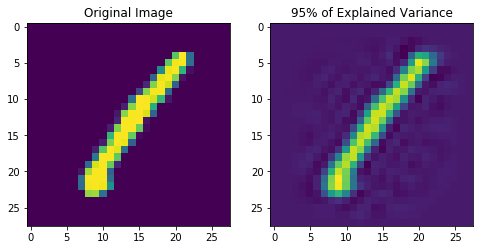

In [10]:
plt.figure(figsize=(8,4));

# Original Image
plt.subplot(1, 2, 1);
plt.imshow(x_train[0, :, :, 0]);
plt.title('Original Image');

# 154 principal components
plt.subplot(1, 2, 2);
plt.imshow(approximation_train[0].reshape(28, 28));
plt.title('95% of Explained Variance');

In [11]:
x_train = approximation_train.reshape(-1, 28, 28, 1)
test_df = approximation_test.reshape(-1, 28, 28, 1)

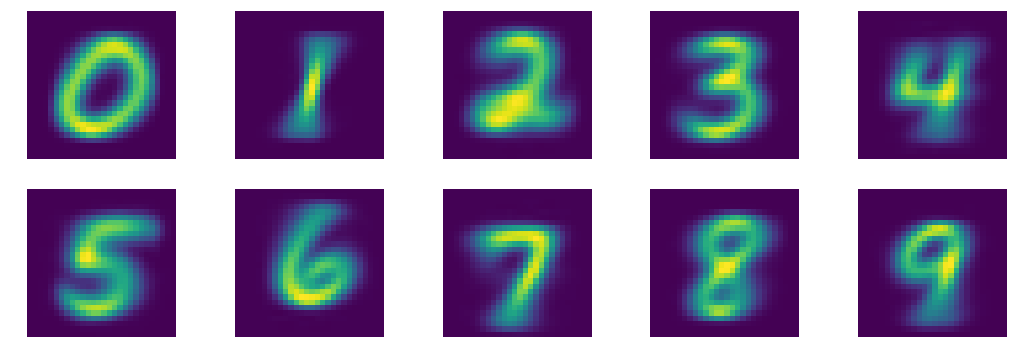

In [12]:
fig, ((ax1, ax2, ax3, ax4, ax5), (ax6, ax7, ax8, ax9, ax10)) = plt.subplots(2, 5, figsize=(18, 6))
ax1.axis('off'), ax2.axis('off'), ax3.axis('off'), ax4.axis('off'), ax5.axis('off'),
ax6.axis('off'), ax7.axis('off'), ax8.axis('off'), ax9.axis('off'), ax10.axis('off'), 

digit = x_train[y_train == 0]
g = ax1.imshow(np.average(digit, 0)[:, :, 0])
digit = x_train[y_train == 1]
g = ax2.imshow(np.average(digit, 0)[:, :, 0])
digit = x_train[y_train == 2]
g = ax3.imshow(np.average(digit, 0)[:, :, 0])
digit = x_train[y_train == 3]
g = ax4.imshow(np.average(digit, 0)[:, :, 0])
digit = x_train[y_train == 4]
g = ax5.imshow(np.average(digit, 0)[:, :, 0])
digit = x_train[y_train == 5]
g = ax6.imshow(np.average(digit, 0)[:, :, 0])
digit = x_train[y_train == 6]
g = ax7.imshow(np.average(digit, 0)[:, :, 0])
digit = x_train[y_train == 7]
g = ax8.imshow(np.average(digit, 0)[:, :, 0])
digit = x_train[y_train == 8]
g = ax9.imshow(np.average(digit, 0)[:, :, 0])
digit = x_train[y_train == 9]
g = ax10.imshow(np.average(digit, 0)[:, :, 0])

# Data Processing

## Categorization

The activation function of the last layer of our CNN will be a softmax function (which will tell the level of certainty with witch the model is about the categorization), so we will one hot encode the categories to achieve better results.

In [13]:
y_train = to_categorical(y_train, num_classes = 10)

## Train-Test Split

Let us split the data into a training (80%) and testing set (20%).

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.10, shuffle = True)

## Data Augmentation

This step is made to generate a new set of data to train the model on from the given data. <br>
Depending on the handwritting, the orientation of number will differ, we need our model to capture the different orientations so we will create additional images from original ones rotating them. In addition, some numbers can be recognized when flipped horizontally and/or vertically, like zero or eight, but some others could be confused with others, like a six and nine. To avoid deceiving the model, we will just zoom and shift on the original data.

In [15]:
datagen = ImageDataGenerator(
        rotation_range=10,       # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1,        # Randomly zoom image 
        width_shift_range=0.1,   # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
)

train_datagen = datagen.flow(x_train, y_train, batch_size=64)
val_datagen = datagen.flow(x_test, y_test, batch_size=64)

# Model Design

In [16]:
def model(input_shape, output_shape):
    
    x = Input(shape=input_shape)
    hidden = Conv2D(32, kernel_size=(3, 3), activation='relu')(x)
    hidden = Conv2D(32, kernel_size=(3, 3), activation='relu')(hidden)
    hidden = MaxPool2D((2, 2))(hidden)
    hidden = Dropout(0.2)(hidden)
    hidden = BatchNormalization()(hidden)
    hidden = Conv2D(64, kernel_size=(3, 3), activation='relu')(hidden)
    hidden = Conv2D(64, kernel_size=(3, 3), activation='relu')(hidden)
    hidden = MaxPool2D((2, 2))(hidden)
    hidden = Dropout(0.2)(hidden)
    hidden = BatchNormalization()(hidden)
    hidden = Conv2D(128, kernel_size = (3,3), activation ='relu')(hidden)
    hidden = Flatten()(hidden)
    hidden = Dense(128, activation='relu')(hidden)
    hidden = BatchNormalization()(hidden)
    hidden = Dropout(0.2)(hidden)
    y = Dense(output_shape, activation='softmax')(hidden)

    return Model(inputs=x, outputs=y)

model = model((x_train.shape[1], x_train.shape[2], 1), 10)

Use the Adam optimizer as it has the best training cost reduction with more epochs. ([ref](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2017/05/Comparison-of-Adam-to-Other-Optimization-Algorithms-Training-a-Multilayer-Perceptron.png)). I will train it with two callbacks: EarlyStopping to avoid overfitting and ReduceLROnPlateau to change the learning rate and improve learning when validation loss does not change.

In [17]:
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

class LossHistory(Callback):
    def __init__(self):
        self.loss = []
        self.val_loss = []
        self.acc = []
        self.val_acc = []
        self.lr = []
    
    def on_epoch_end(self, epoch, logs={}):
        self.val_loss.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_acc'))
        self.loss.append(logs.get('loss'))
        self.acc.append(logs.get('acc'))
        self.lr.append(K.get_value(self.model.optimizer.lr))
        
cb = LossHistory()
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, min_lr=0.000001)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')

model.compile(loss=categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])

Let us now evaluate the untrained model to get a baseline upon which to improve. 

In [18]:
model.evaluate(x_test, y_test)

11200/11200 [==============================] - 3s 264us/step


[2.303406960623605, 0.07598214285714286]

# Training

In [19]:
history = model.fit_generator(train_datagen,
                              epochs = 30,
                              validation_data = val_datagen,
                              verbose = 1,
                              callbacks=[learning_rate_reduction, early_stopping, cb])

Epoch 1/30
1575/1575 [==============================] - 51s 32ms/step - loss: 0.2068 - acc: 0.9356 - val_loss: 0.1090 - val_acc: 0.9679
Epoch 2/30
1575/1575 [==============================] - 50s 32ms/step - loss: 0.0675 - acc: 0.9792 - val_loss: 0.0534 - val_acc: 0.9834
Epoch 3/30
1575/1575 [==============================] - 50s 32ms/step - loss: 0.0540 - acc: 0.9835 - val_loss: 0.0418 - val_acc: 0.9875
Epoch 4/30
1575/1575 [==============================] - 50s 31ms/step - loss: 0.0479 - acc: 0.9855 - val_loss: 0.0308 - val_acc: 0.9905
Epoch 5/30
1575/1575 [==============================] - 50s 31ms/step - loss: 0.0405 - acc: 0.9878 - val_loss: 0.0288 - val_acc: 0.9913
Epoch 6/30
1575/1575 [==============================] - 50s 31ms/step - loss: 0.0372 - acc: 0.9891 - val_loss: 0.0280 - val_acc: 0.9912
Epoch 7/30
1575/1575 [==============================] - 50s 31ms/step - loss: 0.0328 - acc: 0.9903 - val_loss: 0.0229 - val_acc: 0.9929
Epoch 8/30
1575/1575 [==========================

Text(0.5,0,'Epoch')

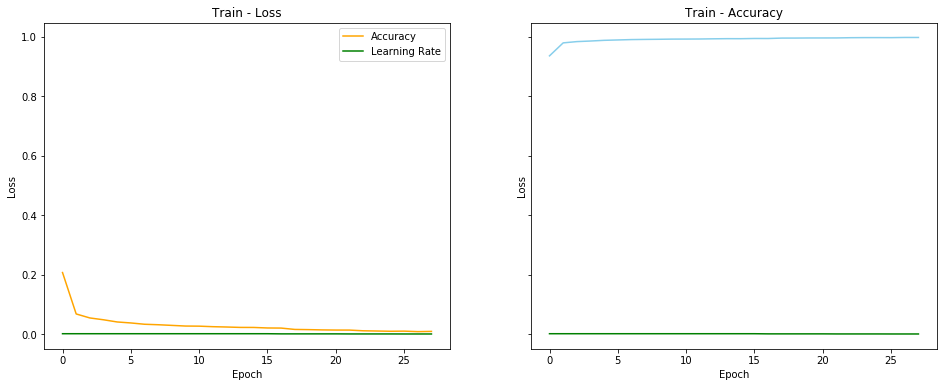

In [20]:
# Graph accuracy
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16,6))

ax1.plot(cb.loss, color='orange')
ax1.plot(cb.lr, color='green')
ax1.legend(['Loss', 'Learning Rate'])
ax1.set_title('Train - Loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')

ax2.plot(cb.acc, color='skyblue')
ax2.plot(cb.lr, color='green')
ax1.legend(['Accuracy', 'Learning Rate'])
ax2.set_title('Train - Accuracy')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')

Text(0.5,0,'Epoch')

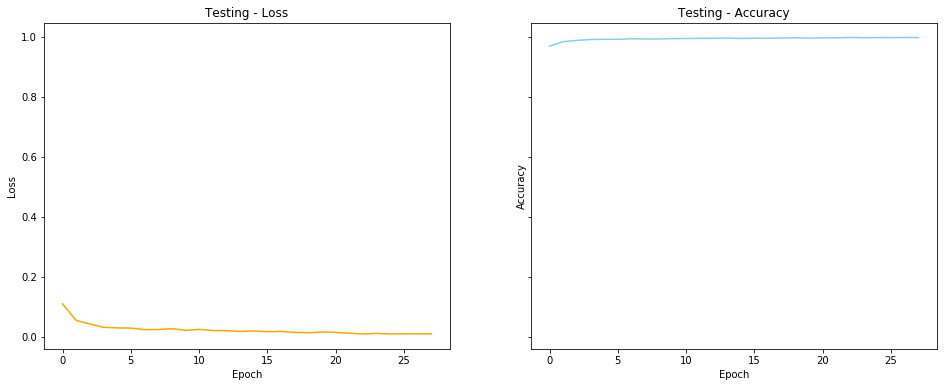

In [21]:
# Graph loss
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16,6))

ax1.plot(cb.val_loss, color='orange')
ax1.set_title('Testing - Loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')

ax2.plot(cb.val_acc, color='skyblue')
ax2.set_title('Testing - Accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')

In [22]:
model.save('model.h5')

# Model Evaluation

Let us look at where the model is wrong with the confusion matrix (we will see if patterns of errors are recurrent).

In [23]:
model.evaluate(x_test, y_test)

11200/11200 [==============================] - 1s 109us/step


[0.006786549871611506, 0.9978571428571429]

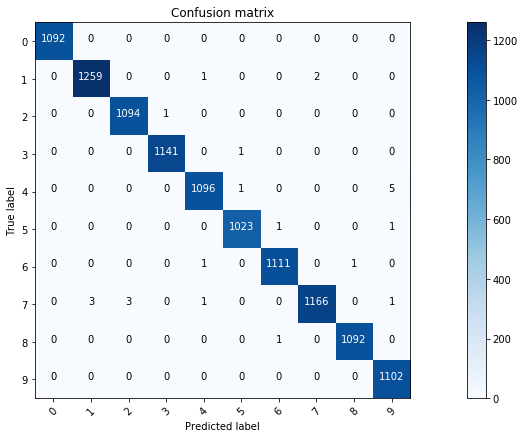

In [24]:
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(16,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis = 1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 


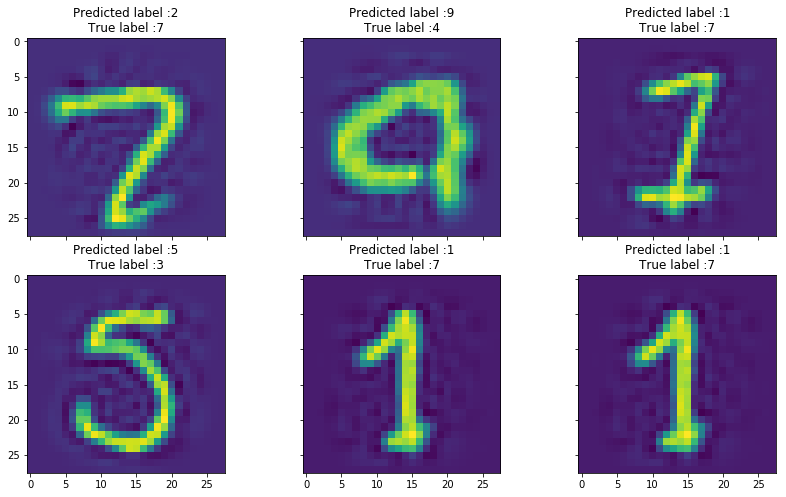

In [25]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (y_pred_classes - y_true != 0)

y_pred_classes_errors = y_pred_classes[errors]
y_pred_errors = y_pred[errors]
y_true_errors = y_true[errors]
x_val_errors = x_test[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(14,8))
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
y_pred_errors_prob = np.max(y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(y_pred_errors, y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, x_val_errors, y_pred_classes_errors, y_true_errors)

# Submission

In [26]:
prediction = model.predict(test_df)
prediction = np.argmax(prediction, axis = 1)
prediction = pd.Series(prediction, name="Label")

In [27]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"), prediction],axis = 1)
submission.to_csv("submission.csv",index=False)